In [0]:
# Install and import TF2
!pip install -q tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3MB 66kB/s 
     |████████████████████████████████| 450kB 57.4MB/s 
     |████████████████████████████████| 3.8MB 57.7MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
2.0.0


In [0]:
# Additional imports
from tensorflow.keras.layers import Input,Dense,Flatten,SimpleRNN,GRU,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# make the synthtic original data
series = np.sin((0.1*np.arange(400))**2) #x(t)=sin(ωt^2)

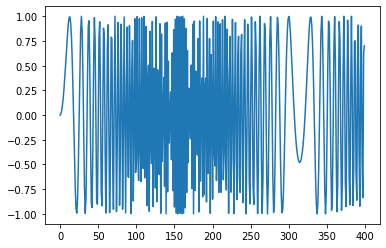

In [0]:
# plot it
plt.plot(series)

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [0]:
# try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(
    loss="mse",
    optimize=Adam(lr=0.01),
)

# train the model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 1s 3ms/sample - loss: 1.6042 - val_loss: 2.4576
Epoch 2/80
195/195 [==============================] - 0s 158us/sample - loss: 1.5639 - val_loss: 2.4247
Epoch 3/80
195/195 [==============================] - 0s 166us/sample - loss: 1.5391 - val_loss: 2.3944
Epoch 4/80
195/195 [==============================] - 0s 156us/sample - loss: 1.5173 - val_loss: 2.3629
Epoch 5/80
195/195 [==============================] - 0s 161us/sample - loss: 1.4953 - val_loss: 2.3371
Epoch 6/80
195/195 [==============================] - 0s 163us/sample - loss: 1.4748 - val_loss: 2.3091
Epoch 7/80
195/195 [==============================] - 0s 161us/sample - loss: 1.4551 - val_loss: 2.2795
Epoch 8/80
195/195 [==============================] - 0s 181us/sample - loss: 1.4349 - val_loss: 2.2579
Epoch 9/80
195/195 [==============================] - 0s 166us/sample - loss: 1.4175 - val_loss: 2.2336
Epoch 10/80
195/195 

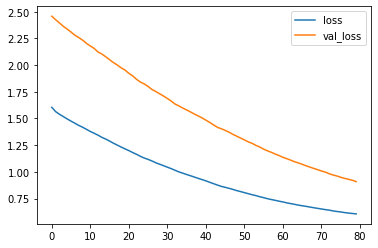

In [0]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


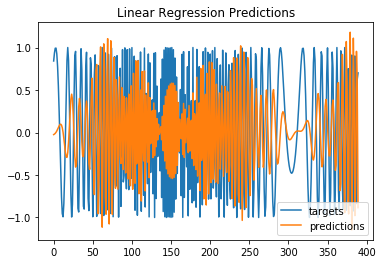

In [0]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()

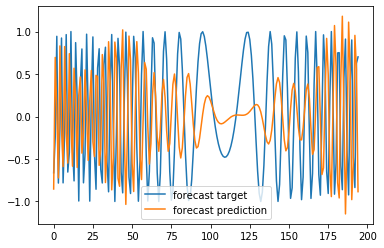

In [0]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1))[0,0] #1x1 array => scalar
  i += 1
  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

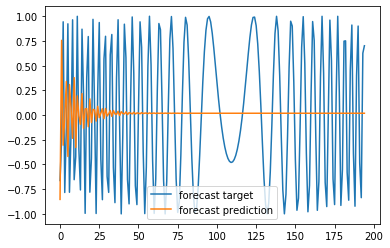

In [0]:
# Forecast future values (use only self-predictions for making predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0] #1x1 array => scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
### Now Try an RNN/LSTM model
X = X.reshape(-1,T,1) # make it NxTxD

# make the RNN
i = Input(shape=(T,D))
# x = SimpleRNN(10)(i)
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
    X[:-N//2],Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 2s 10ms/sample - loss: 0.5369 - val_loss: 0.5160
Epoch 2/200
195/195 [==============================] - 0s 339us/sample - loss: 0.5120 - val_loss: 0.5675
Epoch 3/200
195/195 [==============================] - 0s 341us/sample - loss: 0.4750 - val_loss: 0.5355
Epoch 4/200
195/195 [==============================] - 0s 379us/sample - loss: 0.4205 - val_loss: 0.6370
Epoch 5/200
195/195 [==============================] - 0s 376us/sample - loss: 0.3722 - val_loss: 0.5193
Epoch 6/200
195/195 [==============================] - 0s 399us/sample - loss: 0.3526 - val_loss: 0.4681
Epoch 7/200
195/195 [==============================] - 0s 374us/sample - loss: 0.2685 - val_loss: 0.4047
Epoch 8/200
195/195 [==============================] - 0s 342us/sample - loss: 0.1978 - val_loss: 0.4448
Epoch 9/200
195/195 [==============================] - 0s 347us/sample - loss: 0.1845 - val_loss: 0.3731
Epoch 10/2

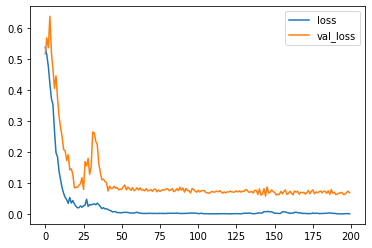

In [0]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


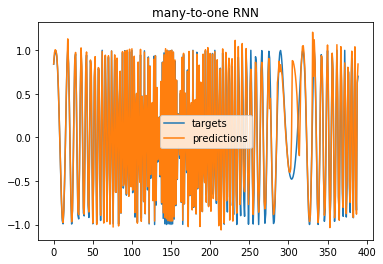

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('many-to-one RNN')
plt.legend()

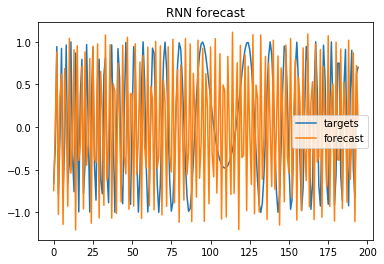

In [0]:
# multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) <len(Y[-N//2:]):
  # reshape the input to NxTxD
  f = model.predict(input_.reshape(1,T,1))[0,0]
  forecast.append(f)

  #make a new input with the latest forecast
  input_ = np.roll(input_,-1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title('RNN forecast')
plt.legend()